In [2]:
%load_ext autoreload
%autoreload 2
import sys
import pyccl as ccl
from multiprocessing import Pool
from pycorr import TwoPointCorrelationFunction, KMeansSubsampler
sys.path.append('../')
import matching_catalog
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from regions import Regions
from regions import CircleSkyRegion, CirclePixelRegion
import AngCorr_prediction
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs


In [3]:
data_path = '/global/cfs/cdirs/desi/users/cpayerne/data_WP221_Target_selection/photometric_tracer_catalogs/'
catalog = Table.read(data_path + 'masked_cosmos_lbg_udropout_rmax25_5.fits')
randoms = Table.read(data_path + 'masked_randoms.fits')

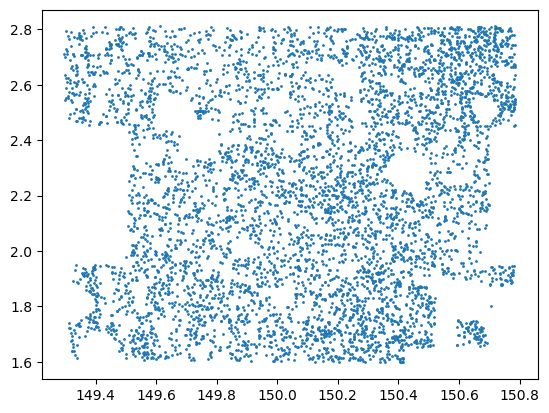

In [10]:
#mask_cat = (catalog['RA'] > 149.5)*(catalog['RA'] < 150.4)*(catalog['DEC'] < 2.8)*(catalog['DEC'] > 1.6)
mask_cat= (catalog['ZPHOT'] > 0) 
mask_cat *= catalog['CLASS_STAR_HSC_I'] < 0.5
#mask_cat *= np.invert((catalog['RA'] > 150.2)*(catalog['RA'] < 151.2)*(catalog['DEC'] < 2)*(catalog['DEC'] > 0.9))
#mask_cat = catalog['RA'] > 0
#mask_cat *= catalog['MAG_ABS_FUV'] < -16
#mask_rand = randoms['RA'] > 0
#mask_rand *= np.invert((randoms['RA'] > 150.2)*(randoms['RA'] < 151.2)*(randoms['DEC'] < 2)*(randoms['DEC'] > 0.9))
#mask_rand *= (randoms['RA'] > 149.5)*(randoms['RA'] < 150.4)*(randoms['DEC'] < 2.8)*(randoms['DEC'] > 1.6)
#plt.scatter(randoms['RA'][mask_rand], randoms['DEC'][mask_rand])
plt.scatter(catalog['RA'][mask_cat], catalog['DEC'][mask_cat], s=1)

In [11]:
(2.8-1.6) * (149.3-150.7)

-1.6799999999999724

In [114]:
def pred(catalog, b):

    z_edges = np.linspace(0, 6, 50)
    z_mid = 0.5 * (z_edges[:-1] + z_edges[1:])

    nz, _ = np.histogram(catalog['ZPHOT'], bins=z_edges)
    nz = nz.astype(float)

    dz = np.diff(z_edges)
    nz /= np.sum(nz * dz)

    theta_deg = np.logspace(np.log10(0.001), np.log10(1.0), 30)

    cosmo = ccl.Cosmology(
        Omega_c=0.27,
        Omega_b=0.315-0.27,
        h=0.67,
        A_s=2.1e-9,
        n_s=0.96
    )

    tracer = ccl.NumberCountsTracer(
        cosmo,
        has_rsd=False,
        dndz=(z_mid, nz),
        bias=(z_mid, np.ones_like(z_mid) * b)
    )

    ell = np.arange(2, 5000)

    cl = ccl.angular_cl(cosmo, tracer, tracer, ell)

    wtheta = ccl.correlation(
        cosmo,
        ell=ell,
        C_ell=cl,
        theta=theta_deg,
        type='NN'
    )

    return theta_deg, wtheta


In [115]:
def AngCorr(catalog, randoms, nsamples=40):

    print(len(catalog))
    z_edges = np.linspace(0, 4, 30)
    z_mid = 0.5 * (z_edges[:-1] + z_edges[1:])
    nz, _ = np.histogram(catalog['ZPHOT'], bins=z_edges)
    nz = nz.astype(float)
    plt.plot(z_mid, nz)

    # FIT ON RANDOMS (important!)
    subsampler = KMeansSubsampler(
        mode='theta',
        positions=[randoms['RA'], randoms['DEC']],
        nsamples=nsamples,
        random_state=42
    )

    data_samples = subsampler.label([catalog['RA'], catalog['DEC']])
    randoms_samples = subsampler.label([randoms['RA'], randoms['DEC']])

    theta_edges = np.logspace(np.log10(0.001), np.log10(0.3), 5)

    corr = TwoPointCorrelationFunction(
        mode='theta',
        edges=theta_edges,
        data_positions1=[catalog['RA'], catalog['DEC']],
        randoms_positions1=[randoms['RA'], randoms['DEC']],
        data_samples1=data_samples,
        randoms_samples1=randoms_samples,
        estimator='landyszalay',
        engine='corrfunc',position_type='rd',
        nthreads=64 )

    theta, wtheta, sig = corr(return_sep=True)

    return theta, wtheta, sig

5710


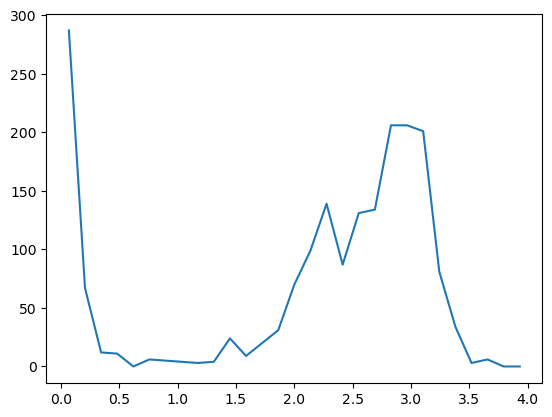

In [116]:
theta_255, wtheta_255, sig_255 = AngCorr(catalog[(catalog['r'] < 25.5)*mask_cat], randoms[mask_rand], 10)

2331


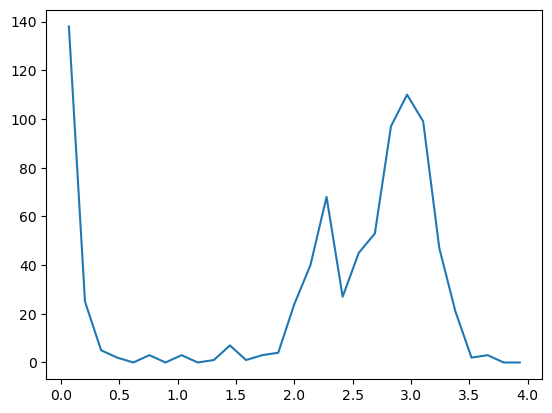

In [117]:
theta_25, wtheta_25, sig_25 = AngCorr(catalog[(catalog['r'] < 24.8)*mask_cat], randoms[mask_rand], 10)

900


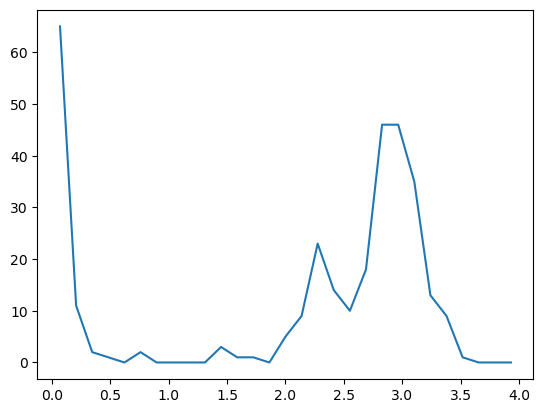

In [118]:
theta_245, wtheta_245, sig_245 = AngCorr(catalog[(catalog['r'] < 24.2)*mask_cat], randoms[mask_rand], 10)

In [119]:
thetath, wthetath = pred(catalog[(catalog['r'] < 24.5)*mask_cat], 5)
thetath2, wthetath2 = pred(catalog[(catalog['r'] < 24.5)*mask_cat], 2)

(0.001, 10)

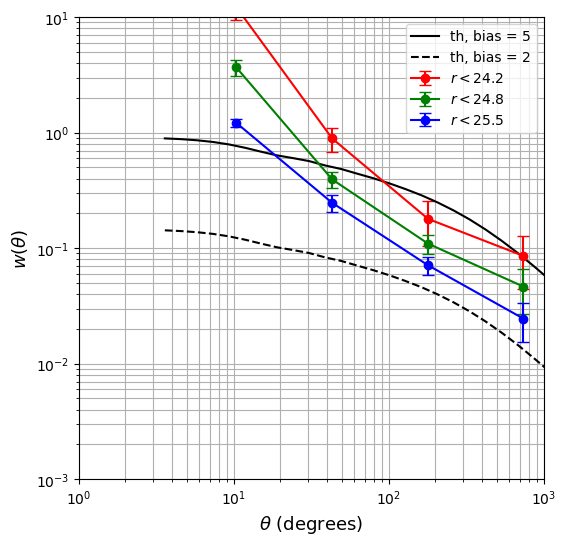

In [120]:
plt.figure(figsize=(6,6))
plt.errorbar(theta_245 * 3600, wtheta_245, sig_245, marker='o', c='r', capsize=4,  fmt='-', label = r'$r < 24.2$')
plt.errorbar(theta_25 * 3600, wtheta_25, sig_25, marker='o', c='g', capsize=4,  fmt='-', label = r'$r < 24.8$')
plt.errorbar(theta_255 * 3600, wtheta_255, sig_255, marker='o', c='b', capsize=4,  fmt='-', label = r'$r < 25.5$')
plt.plot(thetath* 3600, wthetath, 'k', label = 'th, bias = 5')
plt.plot(thetath2* 3600, wthetath2, '--k', label = 'th, bias = 2')
plt.legend()
plt.xscale('log')
plt.xlabel('deg')
plt.ylabel(r'$w(\theta)$', fontsize=13)
plt.xlabel(r'$\theta$ (degrees)', fontsize=13)
plt.yscale('log')
plt.xlim(1, 1e3)
plt.ylim(1e-3, 10)
plt.grid(which='both')
plt.ylim(1e-3, 10)